In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import constants

%matplotlib inline
ox.__version__

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [10]:
%run -i utils.py

<Figure size 640x480 with 0 Axes>

In [2]:
nodes = gpd.read_file("../data/communities_cc/nodes.shp")
edges = gpd.read_file("../data/communities_cc/edges.shp")

In [3]:
nodes = nodes.set_index("osmid")
edges = edges.set_index(['u', 'v', 'key'])

G = ox.utils_graph.graph_from_gdfs(nodes, edges)

In [4]:
nodes.sort_index(inplace=True)

<h1>Coverage</h1>
<p>Given a graph G = (nodes, edges) knowing that in the edges there are some POIs, modify the nodes table to have that: nodes below 15 minutes to at least a POI of a certain category have that category column set to true.</p>
<p>Example: Suppose node i is below 15 minutes to 2 schools, 4 supermarkets and nothing more, then these will be its column values</p>
<table>
  <tr>
    <th>education</th>    
    <th>bank</th>
    <th>healthcare</th>
    <th>transportation</th>    
    <th>food</th>
  </tr>
  <tr>
    <td>True</td>
    <td>False</td>
    <td>False</td>
    <td>False</td>
    <td>True</td>
  </tr>

<h2>Plot graph with all POIs</h2>
<p>We will plot a graph with red nodes representing normal nodes and yellow nodes representing POIs found with the betweenness centrality</p>

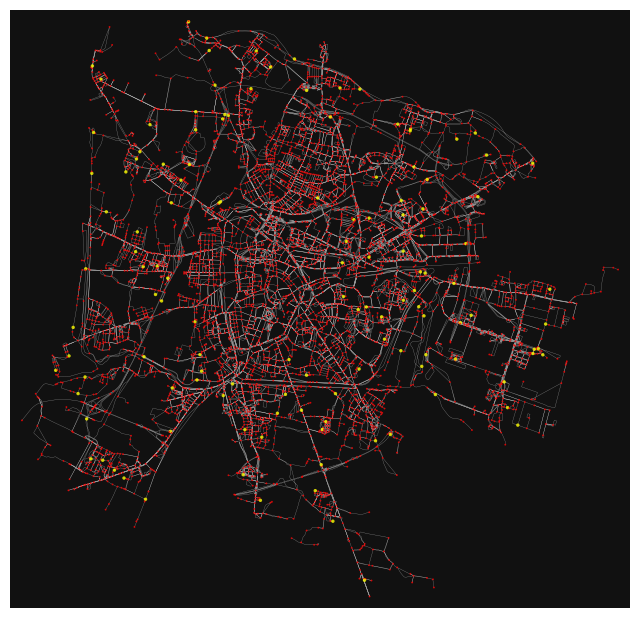

In [5]:
## color the nodes: red - normal; yellow - new POIs
node_colors = {}
node_sizes = {}
for node, data in G.nodes(data=True):
    poi_cc = data.get("cen", False)
    if poi_cc:
        node_colors[node] = "yellow"
        node_sizes[node] = 6
    else:
        node_colors[node] = "red"
        node_sizes[node] = 1.8
        
        
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [node_sizes[node] if node in node_sizes else "none" for node in G.nodes()]

fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

<h2>Plot subgraphs with close nodes for each category</h2>
<p>Plot multiple graphs (one for each category) where blue nodes are POIs, green nodes are the ones near to at least a POI, i.e. covered, red are uncovered nodes (>15 min).</p>

In [6]:
#Create a list of POIs for each category of the new nodes
poi_nodes = {k: [] for k in constants.CATEGORIES}
    
for node, data in G.nodes(data=True):
    for category in constants.CATEGORIES:
        s = f"c_{category}"
        if data[s] == True:
            poi_nodes[category].append(node)    
            
print(sum(len(lst) for lst in poi_nodes.values()))

178


In [7]:
#Compute a subgraph of covered nodes for each category
subgraph_nodes = {k: [] for k in constants.CATEGORIES}
for category in constants.CATEGORIES:
    for poi_id in poi_nodes[category]:
        subgraph = nx.ego_graph(G, poi_id, radius=constants.TRIP_TIME, distance="time", undirected=True)
        subgraph_nodes[category].extend(subgraph)

for c in constants.CATEGORIES:
    print(len(set(subgraph_nodes[c]))) #set() to avoid duplicates

1595
2152
630
1434


In [8]:
#Update nodes table with coverage results
for category in constants.CATEGORIES:
    for node_id in subgraph_nodes[category]:
        nodes.at[node_id, category] = True
G = ox.utils_graph.graph_from_gdfs(nodes, edges)

<h3>Print graph with covered nodes for each category</h3>

Printing graph of covered nodes from  edu
Number of covered nodes (green):  4200
Number of poi nodes (yellow):  94


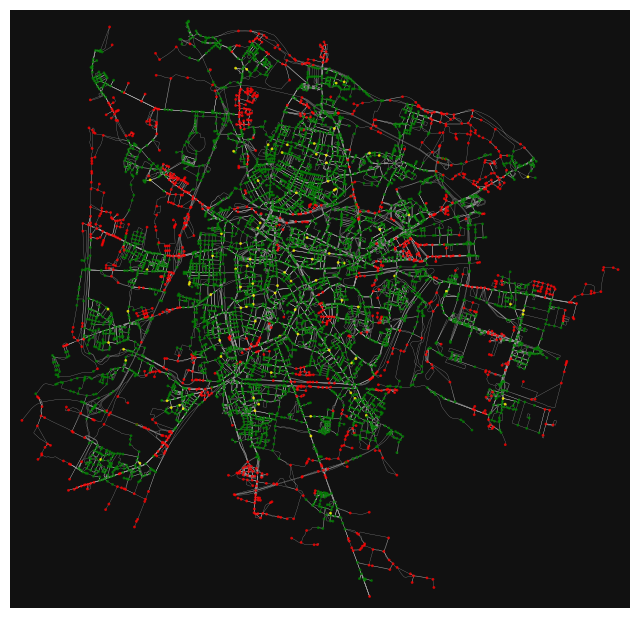

Printing graph of covered nodes from  health
Number of covered nodes (green):  4164
Number of poi nodes (yellow):  64


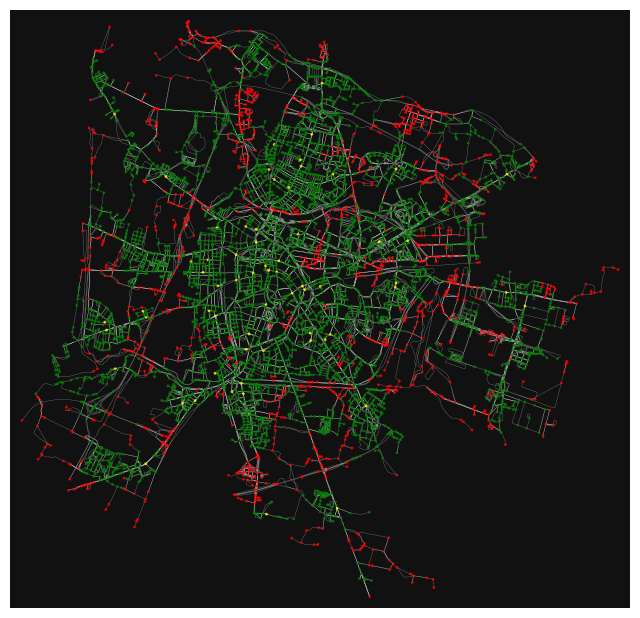

Printing graph of covered nodes from  transp
Number of covered nodes (green):  4714
Number of poi nodes (yellow):  452


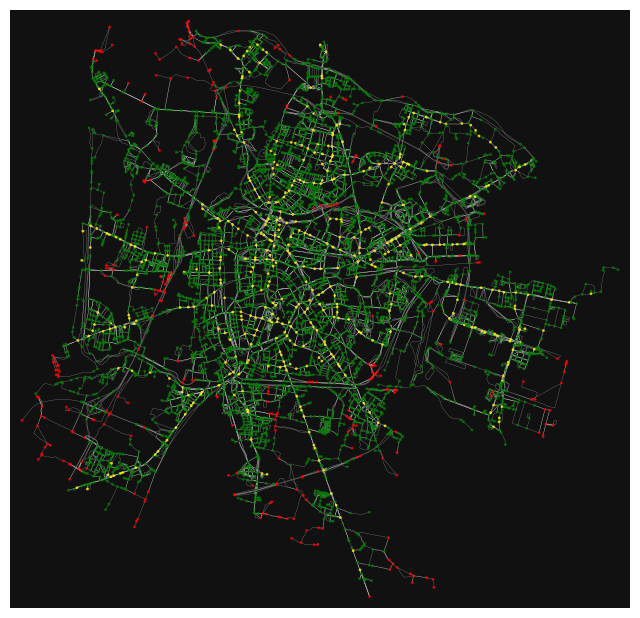

Printing graph of covered nodes from  food
Number of covered nodes (green):  4622
Number of poi nodes (yellow):  120


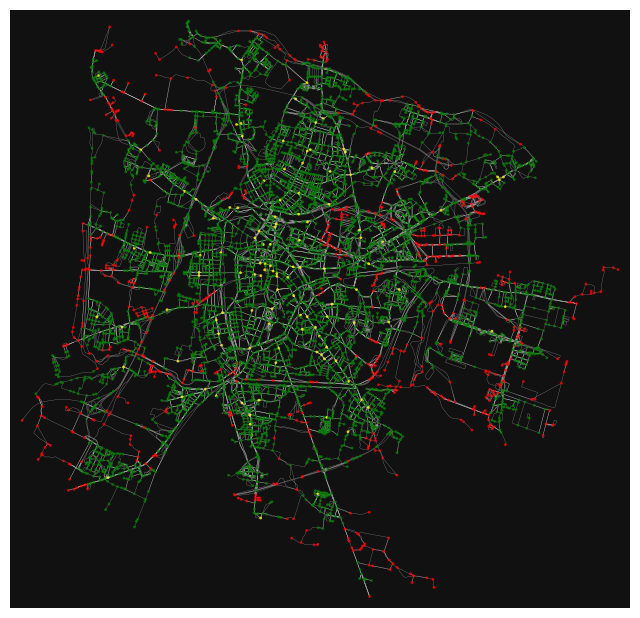

In [11]:
for c in constants.CATEGORIES:
    print("Printing graph of covered nodes from " , c)
    printCoveredNodes(c, G)

<h1>Analysis</h1>
<p>Now that we have obtained all covered nodes for each category we can evaluate some interesting results.</p>

In [12]:
near_all_nodes, isolated_nodes = printTable(G, subgraph_nodes)

<h2>Covered nodes for each category</h2><table><tr><th>Category</th><th>Num. Covered nodes</th><th>Percentage of coverage</th></tr><tr><td>edu</td><td>4200</td><td>76.89%</td></tr><tr><td>health</td><td>4164</td><td>76.24%</td></tr><tr><td>transp</td><td>4714</td><td>86.31%</td></tr><tr><td>food</td><td>4622</td><td>84.62%</td></tr></table>
    <h2>Percentage of nodes covered by all categories</h2>
    <p>The following number is a possible representation of how a city is well covered:</p>
    <table><tr><th>Number of covered nodes</th><th>Total number of nodes</th><th>Percentage of covered nodes</th></tr><tr><td>3504</td><td>5462</td><td>64.15%</td></tr></table>
    <h2>Percentage of isolated nodes</h2>
    <p>These are the nodes that are not near any POI:</p>
    <table><tr><th>Number of isolated nodes</th><th>Total number of nodes</th><th>Percentage of isolated nodes</th></tr><tr><td>129</td><td>5462</td><td>2.36%</td></tr></table>

<h2>Graph plot of nodes covered by all categories and of isolated nodes</h2>

Graph of 15 minutes nodes:
	- yellow: POIs
	- green: Nodes near all constants.CATEGORIES
	- red: Isolated nodes
	- grey: Other nodes


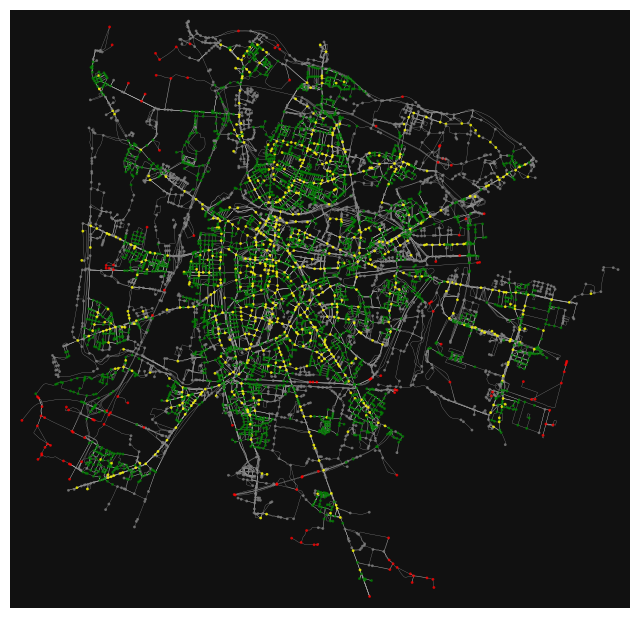

In [13]:
node_colors = []
covered_cnt = 0
poi_cnt = 0
uncovered_cnt = 0

for node, data in G.nodes(data=True):
    if data.get("POI", None) in constants.CATEGORIES:
        node_colors.append("yellow")
    else:
        if node in near_all_nodes:
            node_colors.append("green")  
        elif node in isolated_nodes:
            node_colors.append("red")
        else:
            node_colors.append("grey")  

print("Graph of 15 minutes nodes:\n\t- yellow: POIs\n\t- green: Nodes near all constants.CATEGORIES\n\t- red: Isolated nodes\n\t- grey: Other nodes")
fig, ax = ox.plot_graph(
    G,
    node_color=node_colors,
    node_size=4,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)